In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the data
df_dolar_diario = pd.read_csv('./DadosBrutos/USD_BRL Dados Históricos (2).csv')

# Convert the 'Data' column to datetime format
df_dolar_diario['Data'] = pd.to_datetime(df_dolar_diario['Data'], format='%d.%m.%Y')

# Drop unwanted columns
df_dolar_diario = df_dolar_diario.drop(['Vol.', 'Var%'], axis=1)

# Sort by date in ascending order
df_dolar_diario = df_dolar_diario.sort_values(by='Data', ascending=True)

df_dolar_diario

,Data,Último,Abertura,Máxima,Mínima
534,2023-01-02,"5,3633","5,2865","5,3671","5,2861"
533,2023-01-03,"5,4797","5,3638","5,4802","5,3396"
532,2023-01-04,"5,4312","5,4799","5,4799","5,4248"
531,2023-01-05,"5,3509","5,4315","5,4315","5,3478"
530,2023-01-06,"5,2254","5,3514","5,3697","5,2186"
...,...,...,...,...,...
4,2025-01-13,"6,0944","6,1099","6,1358","6,0748"
3,2025-01-14,"6,0559","6,0979","6,0979","6,0406"
2,2025-01-15,"6,0098","6,0560","6,0701","6,0043"
1,2025-01-16,"6,0499","6,0104","6,0708","5,9935"


In [27]:
# Replace the 'Data' column with sequential integers
df_dolar_diario['Data'] = np.arange(len(df_dolar_diario))

# Ensure numeric columns are correctly formatted (replace commas with dots)
for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df_dolar_diario[col] = df_dolar_diario[col].str.replace(',', '.', regex=False).astype(float)

# Display the cleaned DataFrame
display(df_dolar_diario)

,Data,Último,Abertura,Máxima,Mínima
534,0,5.3633,5.2865,5.3671,5.2861
533,1,5.4797,5.3638,5.4802,5.3396
532,2,5.4312,5.4799,5.4799,5.4248
531,3,5.3509,5.4315,5.4315,5.3478
530,4,5.2254,5.3514,5.3697,5.2186
...,...,...,...,...,...
4,530,6.0944,6.1099,6.1358,6.0748
3,531,6.0559,6.0979,6.0979,6.0406
2,532,6.0098,6.0560,6.0701,6.0043
1,533,6.0499,6.0104,6.0708,5.9935


In [28]:
limite = len(df_dolar_diario) - 10
X_train = df_dolar_diario['Data'].values[:limite].reshape(-1, 1).astype(float)  # Independent variable
y_train = df_dolar_diario['Último'].astype(float).values[:limite]

C:\Users\Mateus\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 50. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


525


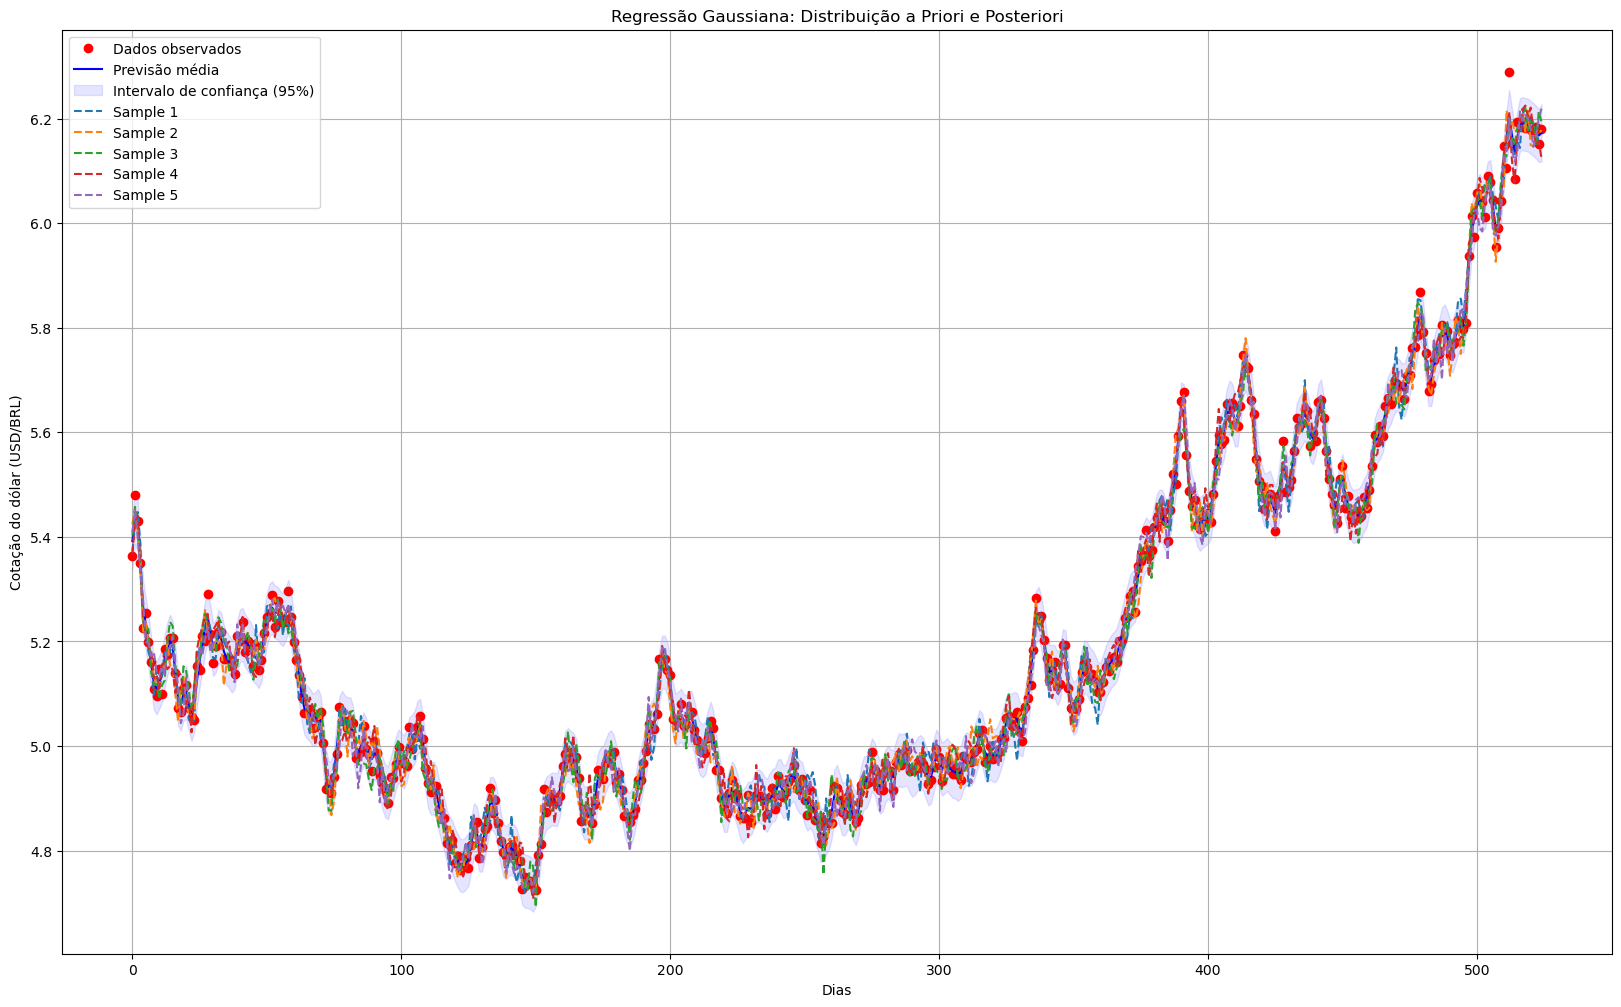

Erro RMSE (Treino): 0.0151


In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel,ExpSineSquared,DotProduct
from sklearn.metrics import root_mean_squared_error
#from skopt import BayesSearchCV

kernel = (
    ConstantKernel(2.0, (0.1, 10)) * RBF(length_scale=10, length_scale_bounds=(1, 50))
    + RationalQuadratic(alpha=0.1, length_scale=5.0)
    + WhiteKernel(noise_level=0.001, noise_level_bounds=(1e-5, 0.1))
)

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, normalize_y=False)

# Treinar o modelo nos dados observados
gpr.fit(X_train, y_train)

X_test = np.arange(0, limite).reshape(-1, 1)
print(len(X_test))
# Fazer previsões e calcular a distribuição posterior
mean_prediction, std_prediction = gpr.predict(X_test, return_std=True)

# Amostrar novos valores a partir da distribuição posterior
n_samples = 5  # Número de amostras
posterior_samples = gpr.sample_y(X_test, n_samples)


# Plotar resultados
plt.figure(figsize=(20, 12))

# Plot da previsão média e intervalo de confiança
plt.plot(X_train, y_train, "o",color='red', label="Dados observados")

plt.plot(X_test, mean_prediction, "b-", label="Previsão média")
plt.fill_between(
    X_test.flatten(),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    color="blue",
    alpha=0.1,
    label="Intervalo de confiança (95%)",
)

# Plot das amostras da distribuição posterior
for i in range(n_samples):
    #if i == 2:
    plt.plot(X_test, posterior_samples[:, i], "--", label=f"Sample {i+1}")

plt.xlabel("Dias")
plt.ylabel("Cotação do dólar (USD/BRL)")
plt.legend()
plt.title("Regressão Gaussiana: Distribuição a Priori e Posteriori")
plt.grid()
plt.show()

y_pred_train, _ = gpr.predict(X_train, return_std=True)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"Erro RMSE (Treino): {rmse_train:.4f}")

9
Erro RMSE (Test): 0.1097


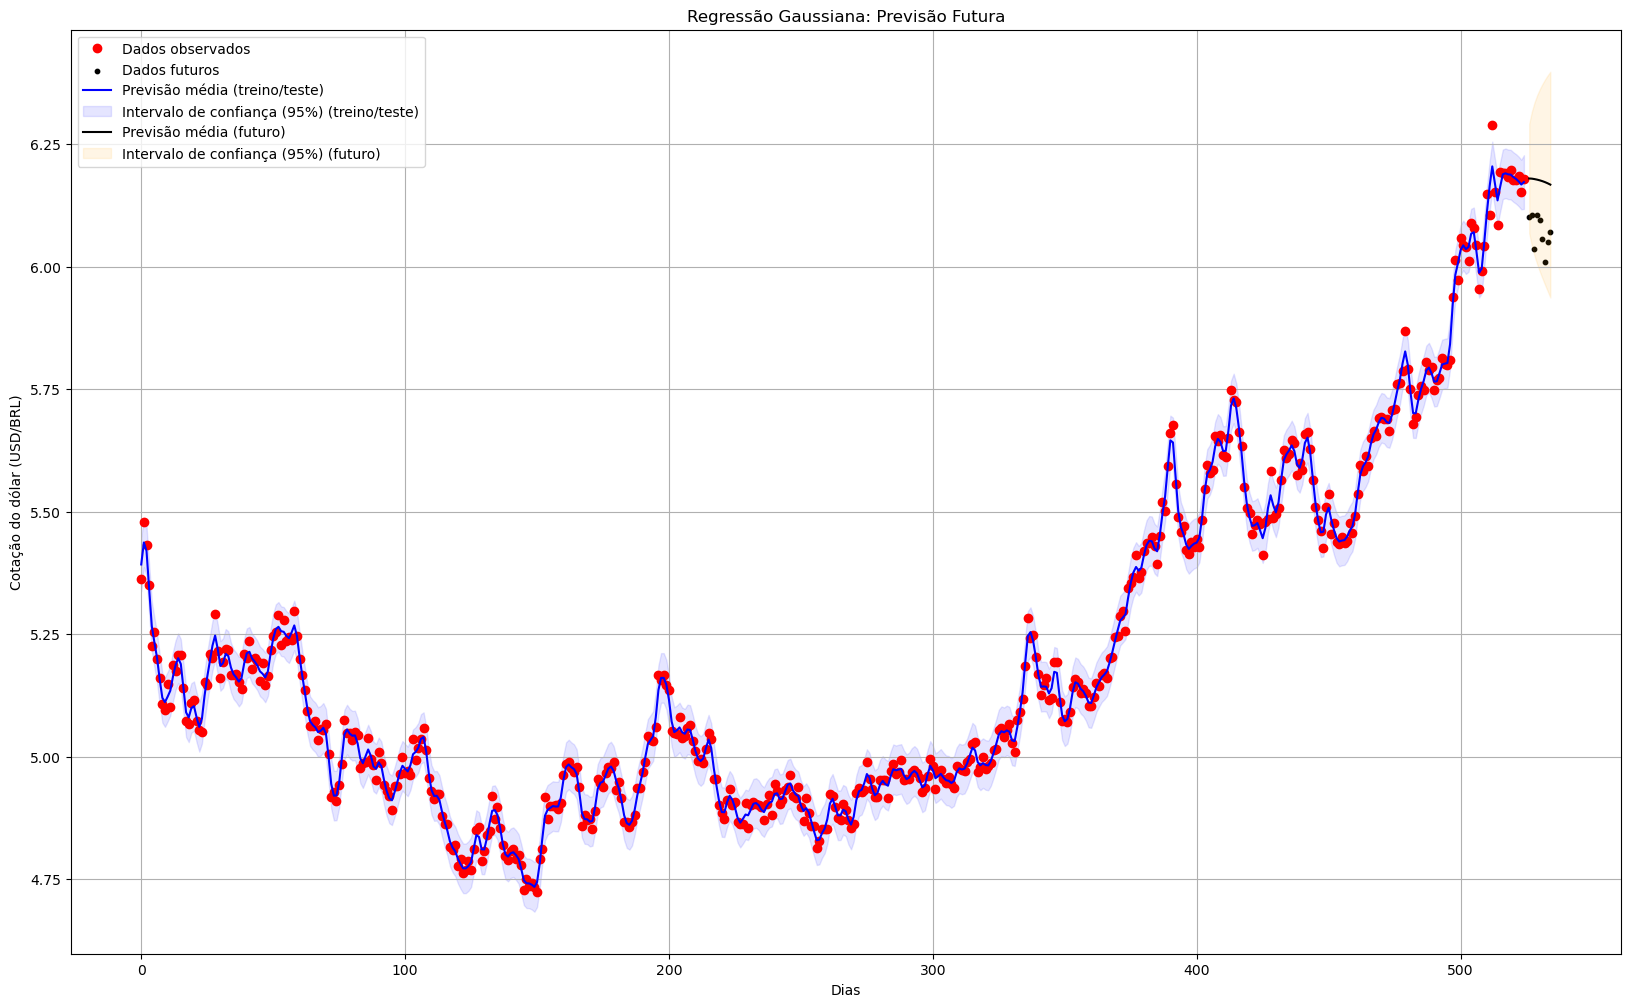

In [30]:
X_future = np.arange(limite + 1, len(df_dolar_diario)).reshape(-1, 1)
y_future = df_dolar_diario['Último'].values[limite+1:]
mean_future, std_future = gpr.predict(X_future, return_std=True)

print(len(X_future))

y_pred_test, _ = gpr.predict(X_future, return_std=True)
rmse_test = root_mean_squared_error(y_future, y_pred_test)
print(f"Erro RMSE (Test): {rmse_test:.4f}")

plt.figure(figsize=(20, 12))

# Plot observed data
plt.plot(X_train, y_train, "o", color="red", label="Dados observados")
plt.scatter(X_future, y_future, color='black', label="Dados futuros", marker='o', s=10)

# Plot predictions for the training range
plt.plot(X_test, mean_prediction, "b-", label="Previsão média (treino/teste)")
plt.fill_between(
    X_test.flatten(),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    color="blue",
    alpha=0.1,
    label="Intervalo de confiança (95%) (treino/teste)"
)

# Plot future predictions
plt.plot(X_future, mean_future, "black", label="Previsão média (futuro)")
plt.fill_between(
    X_future.flatten(),
    mean_future - 2 * std_future,
    mean_future + 2 * std_future,
    color="orange",
    alpha=0.1,
    label="Intervalo de confiança (95%) (futuro)"
)

plt.xlabel("Dias")
plt.ylabel("Cotação do dólar (USD/BRL)")
plt.legend()
plt.title("Regressão Gaussiana: Previsão Futura")
plt.grid()
plt.show()


RMSE for Sample 1: 0.0551
Std: 0.026479532736134435

RMSE for Sample 2: 0.0835
Std: 0.03757478120680614

RMSE for Sample 3: 0.1033
Std: 0.056376964971111165

RMSE for Sample 4: 0.1313
Std: 0.06816478514849371

RMSE for Sample 5: 0.0438
Std: 0.026618576024040615

RMSE for Mean Prediction: 0.1097


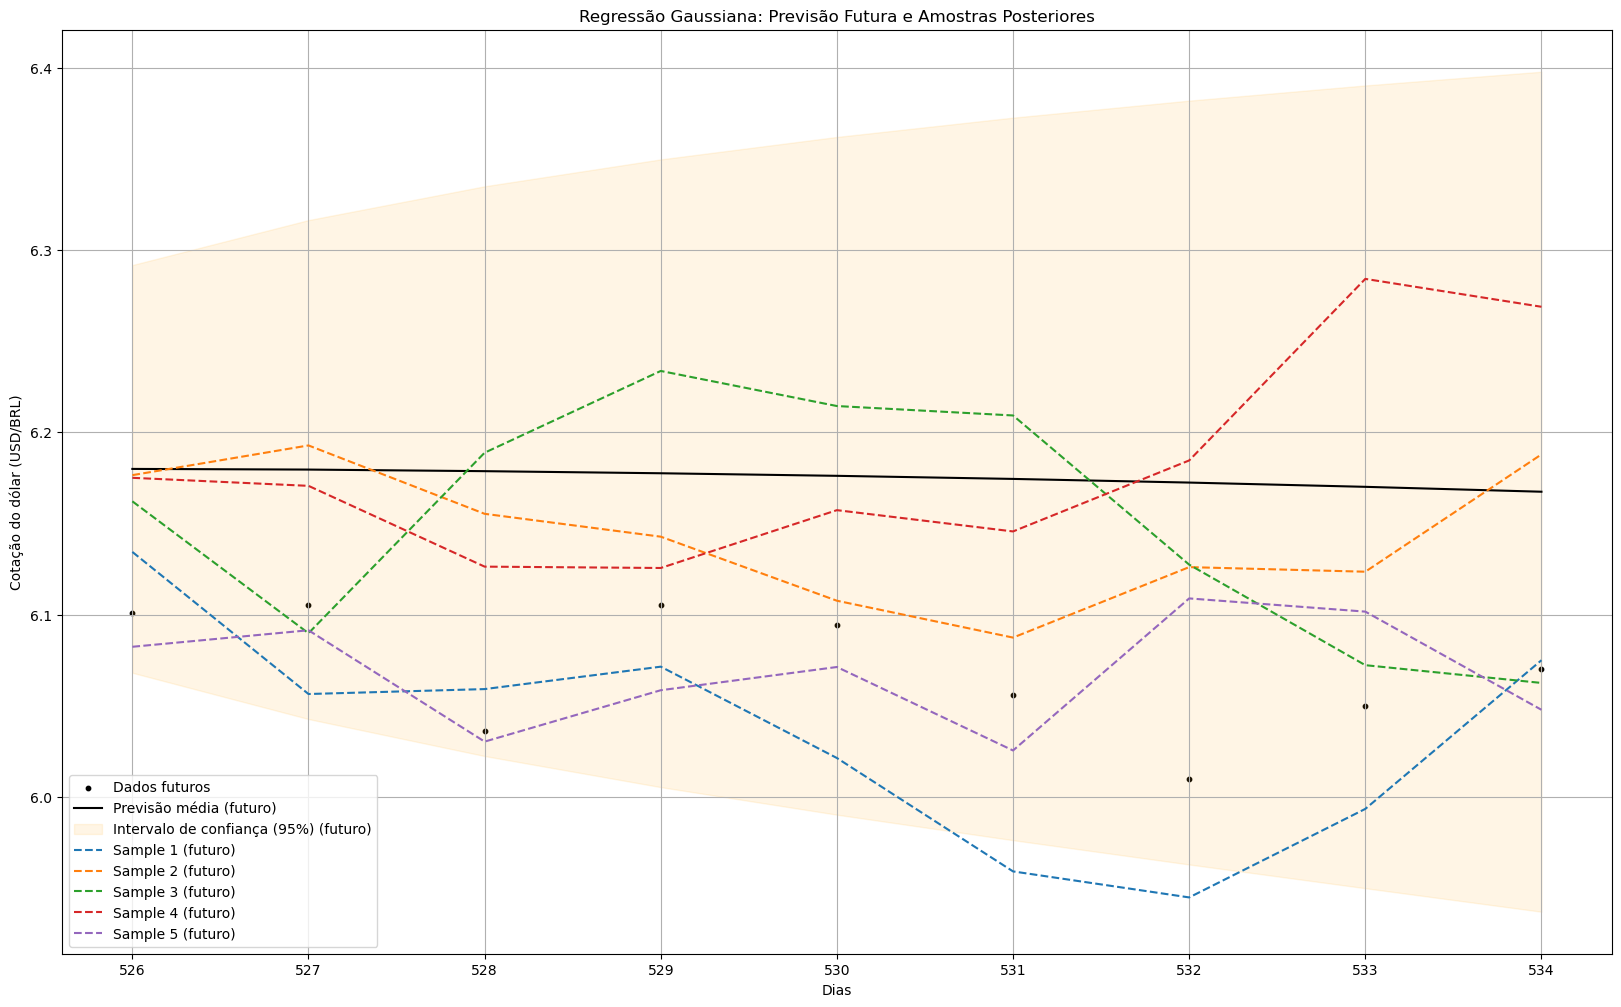

In [31]:
# Predict and calculate uncertainty for future range
mean_future, std_future = gpr.predict(X_future, return_std=True)

# Sample from the posterior for the future range
# n_samples = 5  # Número de amostras
posterior_samples_future = gpr.sample_y(X_future, n_samples)

# Compute RMSE for each posterior sample
rmse_samples = []
for i in range(n_samples):
    rmse_sample = root_mean_squared_error(y_future, posterior_samples_future[:, i])
    rmse_samples.append(rmse_sample)

# Print RMSE for each sample
for i, rmse in enumerate(rmse_samples):
    print(f"RMSE for Sample {i+1}: {rmse:.4f}")
    print(f'Std: {np.std(abs(y_future- posterior_samples_future[:, i]))}\n')

# Compute and print RMSE for the mean prediction (just for comparison)
rmse_mean = root_mean_squared_error(y_future, mean_future)
print(f"RMSE for Mean Prediction: {rmse_mean:.4f}")

plt.figure(figsize=(20, 12))

# # Plot observed data
# plt.plot(X_train, y_train, "o", color="red", label="Dados observados")
plt.scatter(X_future, y_future, color='black', label="Dados futuros", marker='o', s=10)

# # Plot predictions for the training range
# plt.plot(X_test, mean_prediction, "b-", label="Previsão média (treino/teste)")
# plt.fill_between(
#     X_test.flatten(),
#     mean_prediction - 2 * std_prediction,
#     mean_prediction + 2 * std_prediction,
#     color="blue",
#     alpha=0.1,
#     label="Intervalo de confiança (95%) (treino/teste)"
# )

# Plot future predictions
plt.plot(X_future, mean_future, "black", label="Previsão média (futuro)")
plt.fill_between(
    X_future.flatten(),
    mean_future - 2 * std_future,
    mean_future + 2 * std_future,
    color="orange",
    alpha=0.1,
    label="Intervalo de confiança (95%) (futuro)"
)

# Plot the sampled future predictions
for i in range(n_samples):
    plt.plot(X_future, posterior_samples_future[:, i], "--", label=f"Sample {i+1} (futuro)")

plt.xlabel("Dias")
plt.ylabel("Cotação do dólar (USD/BRL)")
plt.legend()
plt.title("Regressão Gaussiana: Previsão Futura e Amostras Posteriores")
plt.grid()
plt.show()
